# Remote Sensing - Exploring Black Marble Imagery at Penn State

## Environment Setup

### Import Packages

In [1]:
# Import packages
import os
import re
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.transform import from_origin
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em

### Set Package Options

In [2]:
# Set options
sns.set(font_scale=1.5)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Define Functions

In [3]:
def get_radiance_data(radiance_df, year, month, day=None):
    """Returns a list of single-day radiance (values or
    cloud mask values) dataframes based on the specified 
    month and year.

    YYYY-MM-DD

    Parameters
    ----------
    radiance_df : pandas dataframe
        Dataframe indexed by pixel ID containing the 
        radiance data by date (columns).

    year : str
        Four-digit year (YYYY).

    month : str
        Two-digit month (MM), with leading 0s
        (ex: 01, 02, 03, 10).

    day : str
        One (M) or two-digit (MM) month, with
        leading 0s (ex: 01, 02, 03, 10).

    Returns
    -------

    Example
    -------
        >>> radience_data = get_radiance_data(radiance_df, year='2019', month='09')
        >>>
        >>>
        >>>
    """
    # Get radiance data (values or cloud mask) dataframes into list
    radiance = [radiance_df[[col]]
                for col in radiance_df.columns
                if re.compile(f"^{year}-{month}-(0[1-9]|[12]\d|3[01])$").match(col)]

    return radiance

In [4]:
### REMOVE - THE DATE FORMAT ISSUE IS RESOLVED WITH THE MISSING DATA FUNCTION ###
# def get_cloud_mask_data(cloud_mask_df, year, month, day=None):
#     """Returns a list of single-day cloud mask
#     dataframes based on the specified month and year.

#     M(M)/D(D)/YYYY

#     Parameters
#     ----------
#     cloud_mask_df : pandas dataframe
#         Dataframe indexed by pixel ID containing the 
#         cloud mask data by date (columns).

#     year : str
#         Four-digit year (YYYY).

#     month : str
#         One (M) or two-digit (MM) month, without 
#         leading 0s (ex: 1, 2, 3, 10).

#     day : str
#         One (M) or two-digit (MM) day, without 
#         leading 0s (ex: 1, 2, 3, 10).  

#     Returns
#     -------

#     Example
#     -------
#         >>> mask_data = get_cloud_mask_data(mask_df, year='2019', month='9') 
#         >>>
#         >>>
#         >>>
#     """
#     # Get cloud mask value dataframes into list
#     cloud_mask = [cloud_mask_df[[col]]
#                   for col in cloud_mask_df.columns
#                   if re.compile(f"^{month}/([1-9]|[12]\d|3[01])/{year}$").match(col)]

#     return cloud_mask

In [5]:
def get_psu_array(radiance_data):
    """Extracts radiance and cloud mask data into a 
    correctly-shaped array for the Penn State campus.
    
    Meant for specific use with the Penn State campus data.
    
    Parameters
    ----------
    radiance_data : pandas dataframe
        Dataframe containing the radiance data
        (radiance values or cloud mask values).
    
    Returns
    -------
    N/A : numpy array
        Numpy array containg the formatted radiance data
        (radiance values or cloud mask values).
    
    Example
    ------
        >>> import pandas as pd 
        >>> radiance_df = pd.read_csv(radiance_path)
        >>> radiance_arr = get_psu_array(radiance_df)
    """
    # Convert dataframe to numpy array, reshape array, and transpose array
    return radiance_data.to_numpy().reshape((40,18)).transpose()

In [47]:
def calculate_mean_radiance(radiance_data, cloud_mask_data):
    """
    Parameters
    ----------
    radiance_data : list (of pandas dataframes)
        List containing individual day radiance values
        for all pixels in the study area.

    cloud_mask_data : list (of pandas dataframes)
        List containing individual day cloud mask 
        values for all pixels in the study area.

    Returns
    -------
    mean_radiance : numpy array (possibly masked)
        Numpy array containing mean radiance values
        for the study area, over the time period of
        the input data.
        
    Example
    -------
        >>>
        >>>
        >>>
        >>>
    """
    # Create lists of numpy arrays from lists of dataframes
    radiance_arrays = list(map(get_psu_array, radiance_data))
    cloud_mask_arrays = list(map(get_psu_array, cloud_mask_data))

    # Zip lists together to match up (tuple) radiance value array with cloud mask array
    zipped_arrays = list(zip(radiance_arrays, cloud_mask_arrays))

    # Create list of masked arrays (based on data/mask tuples)
    # Initialize list
    radiance_masked_arrays = []

    # Loop through each tuple
    for radiance_mask_tuple in zipped_arrays:

        # Check if array should be masked (includes mask value)
        if 100 in radiance_mask_tuple[1]:

            # Mask with clouad mask value
            radiance_cloud_free = em.mask_pixels(
                radiance_mask_tuple[0],
                radiance_mask_tuple[1],
                vals=[100])

            # Append masked array to list of arrays
            radiance_masked_arrays.append(radiance_cloud_free)

        # If no mask value
        else:

            # Append original (cloud-free) array to list of arrays
            radiance_masked_arrays.append(radiance_mask_tuple[0])

    # Create stack of numpy arrays (3d array) of cloud free data
    radiance_masked_stack = np.stack(radiance_masked_arrays)
    
    # Get mean value for each pixel, over all arrays (bands)
    radiance_masked_stack_mean = np.nanmean(radiance_masked_stack, axis=0)
    
    # Return mean
    return radiance_masked_stack_mean

In [7]:
def export_to_geotiff(array, output_path, metadata):
    """Exports a numpy array to a GeoTiff.

    Parameters
    ----------
    array : numpy array
        Numpy array to be exported to GeoTiff.

    output_path : str
        Path to the output file (includeing filename).

    metadata : dict
        Dictionary containing the metadata required 
        for export.

    Returns
    -------
    N/A : str
        Message indicating success or failure or export.

    Example
    -------
        >>>
        >>>
        >>>
        >>>
    """
    try:
        # Write numpy array to GeoTiff
        with rio.open(output_path, 'w', **metadata) as dst:
            dst.write(array, 1)

    except Exception as error:
        message = f"ERROR: {error}"

    else:
        message = f"Exported {output_path}"

    return print(message)

In [155]:
def create_day_list(start_year_month_day, end_year_month_day):
    """Creates a list of (YEAR, MONTH, DAY) tuples for iteration.

    Parameters
    ----------
    start_year_month_day : str

    end_year_month_day : str

    Returns
    -------
    month_list : list (of tuples)
        List containing (YEAR, MONTH, DAY) tuples.

    Example
    -------
        >>> dates = create_date_list('2019-09-01', '2020-04'-30)
        >>>
        >>>
    """
   # Initialize month list
    date_list = []

    # Extract start and end years/months
    start_year = int(start_year_month_day.split('-')[0])
    start_month = int(start_year_month_day.split('-')[1])
    start_day = int(start_year_month_day.split('-')[2])
    end_year = int(end_year_month_day.split('-')[0])
    end_month = int(end_year_month_day.split('-')[1])
    end_day = int(end_year_month_day.split('-')[2])

    # Set conditions for invalid date range
    year_cond = (start_year > end_year)
    month_cond = (start_year == end_year and start_month > end_month)
    day_cond = (start_year == end_year and start_month ==
                end_month and start_day > end_day)

    # Check if start year is after end year - figure out combinations
    if year_cond or month_cond or day_cond:
        raise ValueError("Start date is after end date.")

    # Define starting values
    year = start_year
    month = start_month
    day = start_day

    # Define max days in each month
    max_days = {
        1: 31,
        2: 28,
        3: 31,
        4: 30,
        5: 31,
        6: 30,
        7: 31,
        8: 31,
        9: 30,
        10: 31,
        11: 30,
        12: 31
    }

    # While dates are within start/end
    while (year <= end_year) and (month <= end_month):

        # Pad with 0 if one digit
        day_str = '0' + str(day) if len(str(day)) == 1 else str(day)
        month_str = '0' + str(month) if len(str(month)) == 1 else str(month)
        year_str = str(year)

        # Add date to list
        date_list.append((year_str, month_str, day_str))

        # Increment day
        day += 1

#         print(day)

        # Increment month if need be
        if day % max_days.get(month) == 1:
            day = 1
            month += 1
            if month % 12 == 1:
                month = 1
                year += 1

#         print(day)
#         print(month)

        # Increment year if need be
#         if month % 12 == 1:
#             month = 1
#             year += 1

#         print(month)
#         print(year)

#         print("Day:", day, "End day:", end_day, "Month:", month, "End month:", end_month, "Year:", year, "End Year", end_year)

        # Break loop once year/month/day passes specified end
        if (year == end_year) and (month == end_month) and (day > end_day):
            break

    return date_list

Function that takes pd.date_range, strips it based on monthly or daily (user input)

```python
pd.date_range('2019-12-01', '2020-01-31', freq='W-MON')
```

User specifies if they want monthly (full month or certain days withtin the month)

In [181]:
start = '2019-12-01'
end = '2020-01-31'

date_range = pd.date_range(start, end)

In [182]:
date_range

DatetimeIndex(['2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15', '2019-12-16',
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-21', '2019-12-22', '2019-12-23', '2019-12-24',
               '2019-12-25', '2019-12-26', '2019-12-27', '2019-12-28',
               '2019-12-29', '2019-12-30', '2019-12-31', '2020-01-01',
               '2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-11', '2020-01-12', '2020-01-13',
               '2020-01-14', '2020-01-15', '2020-01-16', '2020-01-17',
               '2020-01-18', '2020-01-19', '2020-01-20', '2020-01-21',
               '2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
      

In [184]:
temp = []
list(set([date.strftime("%Y-%m") for date in date_range]))

['2020-01', '2019-12']

In [203]:
def get_date_list(start_date, end_date, date_aggregation='daily', date_frequency='D'):
    """Returns a list of dates in YYYY-MM-DD format,
    within the specified range and frequency.

    date_aggregation : str
        Can be 'daily' or 'monthly'.

    """
    # Create pandas date range (all days) with start and end date
    date_range = pd.date_range(start_date, end_date, freq=date_frequency)

    # Create list of dates (as strings) formatted to YYYY-MM-DD (daily)
    #  or YYYY-MM (monthly)
    date_list = [date.strftime("%Y-%m-%d") for date in date_range] if date_aggregation == 'daily' else list(
        dict.fromkeys([date.strftime("%Y-%m") for date in date_range]))

    # Return list of dates
    return date_list

In [207]:
date_list = get_date_list('2019-12-01', '2019-12-01', date_aggregation='daily', date_frequency='W-SUN')
date_list

['2019-12-01']

In [205]:
create_day_list('2019-12-30', '2020-01-02')

[]

In [ ]:
create_day_list('2020-12-30', '2020-01-02')

In [ ]:
# Need function for single-pixel masked radiance throughout full date range

In [83]:
def create_date_list(start_year_month, end_year_month):
    """Creates a list of (YEAR, MONTH) tuples for iteration.

    Parameters
    ----------
    start_year_month : str

    end_year_month : str

    Returns
    -------
    month_list : list (of tuples)
        List containing (YEAR, MONTH) tuples.

    Example
    -------
        >>> dates = create_date_list('2019-09', '2020-03')
        >>>
        >>>
    """
   # Initialize month list
    date_list = []

    # Extract start and end years/months
    start_year = int(start_year_month.split('-')[0])
    start_month = int(start_year_month.split('-')[1])
    end_year = int(end_year_month.split('-')[0])
    end_month = int(end_year_month.split('-')[1])
        
    # Check if start year is after end year - figure out combinations
    if (start_year > end_year) or (start_year == end_year and start_month > end_month):
        raise ValueError("Start date is after end date.")
    
    year = start_year
    month = start_month
    
    # While dates are within start/end
    while (year <= end_year):
        
        # Pad with 0 if one digit
        month_str = '0' + str(month) if len(str(month)) == 1 else str(month)
        year_str = str(year)

        # Add date to list
        date_list.append((year_str, month_str))

        # Increment month; reset month and increment year if needed
        month += 1

        if month % 12 == 1:
            month = 1
            year += 1

        # Break loop once year/month passes specified end
        if (year == end_year and month > end_month):
            break

    return date_list

In [11]:
# Function to store mean radiance data in an dictionary
def store_mean_radiance(radiance_df, cloud_mask_df, date_list):
    """Stores mean radiance data in a dictionary.
    """    
    # Create dictionary to store mean radiance data
    mean_radiance_dict = {}

    # Loop through year/date combinations
    for year, month in date_list:

        # Add year to dictionary if existing key
        if year not in mean_radiance_dict.keys():
            mean_radiance_dict[year] = {}

        # Get radiance data
        radiance = get_radiance_data(
            radiance_df, year=year, month=month)

        # Get cloud mask data
        cloud_mask = get_radiance_data(
            cloud_mask_df, year=year, month=month)

        # Calculate mean radiance
        mean_radiance = calculate_mean_radiance(
            radiance, cloud_mask)

        # Add monthly mean radiance to dictionary (as nested dictionary)
        mean_radiance_dict[year][month] = mean_radiance
        
    return mean_radiance_dict

In [12]:
def add_missing_data(df, start_date, end_date):
    """Adds entries for missing dates and populates
    the data for those dates with NaN values.

    Meant for use with radiance values or cloud mask 
    values and assumed dates are columns (not indices).

    Parameters
    ----------
    df : pandas dataframe
        Dataframe with missing dates.

    Returns
    -------
    filled_df : pandas dataframe
        Dataframe with full date range and 
        NaN values for data added.

    Example
    -------
        >>> filled = add_missing_data(radiance, '2019-09-01', '2020-04-30')
        >>>
        >>>
    """
    # Create copy of dataframe (avoids changing the original)
    df_copy = df.copy()

    # Transpose dataframe to get dates an indices
    transposed_df = df_copy.transpose()

    # Create pandas class of current indices (not full range)
    transposed_df.index = pd.DatetimeIndex(transposed_df.index)

    # Create index for full date range
    full_date_range_index = pd.date_range(start_date, end_date)

    # Add missing dates, with NaN values for data
    transposed_df_filled = transposed_df.reindex(
        full_date_range_index, fill_value=np.NaN)

    # Transpose dataframe back to pixel IDs as indices
    filled_df = transposed_df_filled.transpose()
    
    # Change all column names to str (from datetime)
    filled_df.columns = filled_df.columns.strftime("%Y-%m-%d")

    # Return filled dataframe
    return filled_df

### Set Working Directory

In [13]:
# Set working directory
working_directory = os.path.join(
    et.io.HOME, "PSU", "08-covid19-remote-sensing-fusion",
    "00-git-repos", "penn-state-radiance")

## Data Preparation

### Define File Paths

In [14]:
# Set path to radiance files
radiance_directory = os.path.join(
    working_directory, "02-raw-data", "radiance_files")

psu_lat_lon_path = os.path.join(
    radiance_directory, "PSU_Pixel_LatLongs.csv")

psu_radiance_path = os.path.join(
    radiance_directory, "PSU_Radiance_RavelOrderF.csv")

psu_cloud_mask_path = os.path.join(
    radiance_directory, "PSU_CloudMask_RavelOrderF.csv")

In [15]:
# Check that all paths to files exist
for path in [psu_lat_lon_path, psu_radiance_path, psu_cloud_mask_path]:
    print(f"Path exists: {path}") if os.path.exists(
        path) else print(f"Path does not exist: {path}")

Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\radiance_files\PSU_Pixel_LatLongs.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\radiance_files\PSU_Radiance_RavelOrderF.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\radiance_files\PSU_CloudMask_RavelOrderF.csv


### Read CSV Files to Geodataframes

In [16]:
# Read lat/lon into dataframe
psu_lat_lon_df = pd.read_csv(psu_lat_lon_path)

In [17]:
# Display dataframe
psu_lat_lon_df.head()

,ID,Latitude,Longitude
0,0,40.829917,-77.937355
1,1,40.825751,-77.937355
2,2,40.821584,-77.937355
3,3,40.817417,-77.937355
4,4,40.813251,-77.937355


In [18]:
# Read radiance values to dataframe
psu_radiance_df = pd.read_csv(psu_radiance_path)

In [19]:
psu_radiance_df.head()

,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-17,2019-09-18,2019-09-19,2019-09-20,2019-09-22,2019-09-23,2019-09-25,2019-09-26,2019-09-27,2019-09-28,2019-10-01,2019-10-02,2019-10-04,2019-10-05,2019-10-06,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-17,2019-10-18,2019-10-19,2019-10-20,2019-10-21,2019-10-22,2019-10-23,2019-10-24,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-30,2019-11-01,2019-11-02,2019-11-03,2019-11-05,2019-11-06,2019-11-08,2019-11-09,2019-11-10,2019-11-11,2019-11-14,2019-11-15,2019-11-16,2019-11-17,2019-11-18,2019-11-19,2019-11-21,2019-11-22,2019-11-23,2019-11-24,2019-11-25,2019-11-27,2019-11-28,2019-11-29,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-25,2020-04-26,2020-04-27,2020-04-28
0,12,6,9,7,14,7,7,16,10,35,103,194,34,38,22,22,24,11,88,6,10,9,11,7,10,8,6,15,9,47,11,22,33,37,86,41,110,73,20,57,25,16,14,8,146,24,7,9,10,12,10,10,19,7,14,19,46,148,116,34,98,29,52,24,13,11,13,3,7,21,16,19,16,33,17,5,14,27,18,33,86,92,176,132,116,185,155,70,68,21,18,17,8,25,6,11,12,11,25,9,8,14,10,9,12,11,17,45,88,116,157,254,225,57,70,18,30,36,24,20,22,17,23,53,9,25,7,13,8,11,14,7,11,4,35,67,61,227,353,294,152,43,82,41,10,30,12,7,10,10,12,12,6,6,16,13,17,16,15,8,10,13,13,15,18,122,38,95,189,33,47,65,17,23,11,6,11,6,3,10,9,6,7,1,6,5,10,6,24,7,9,6,4,14
1,11,6,9,7,14,15,11,16,18,44,103,194,34,45,22,32,24,13,88,27,18,9,11,9,10,18,25,15,9,47,24,22,37,39,86,41,113,73,20,61,25,16,22,13,146,28,7,15,12,12,20,29,20,16,20,18,51,151,116,102,104,44,52,24,22,11,13,3,12,21,22,19,16,33,27,4,17,27,18,41,100,95,190,132,123,175,155,70,71,28,19,17,7,25,8,17,17,11,25,9,9,20,81,9,10,19,17,47,88,119,157,242,233,57,76,26,35,50,25,31,43,17,29,56,10,23,9,20,16,11,21,7,11,59,35,62,62,227,353,293,159,44,83,40,10,34,12,7,10,15,12,12,17,9,18,14,17,16,26,54,20,16,13,29,30,124,41,95,189,45,50,66,18,24,11,8,12,6,3,10,22,7,7,1,13,5,10,7,24,10,14,4,7,17
2,11,6,17,18,35,60,11,15,18,41,105,197,50,98,42,32,31,14,31,27,44,18,85,7,18,16,25,17,15,24,24,48,51,133,86,36,109,73,20,61,35,14,19,23,16,28,7,15,12,19,20,31,20,46,20,18,75,153,118,102,104,44,58,31,18,19,29,3,16,27,29,30,17,35,41,4,17,34,25,41,100,96,189,133,133,175,147,74,69,32,29,19,7,15,31,17,17,14,36,5,11,21,81,9,10,19,19,47,98,162,158,242,239,89,76,26,35,50,25,89,43,81,29,56,10,25,9,20,16,40,21,7,14,27,42,62,62,243,359,293,160,48,83,43,18,34,12,7,31,19,25,38,17,9,18,14,19,26,26,54,36,16,16,154,92,132,44,96,193,45,61,66,91,25,23,9,12,4,6,12,22,9,18,2,20,7,9,7,40,11,15,4,7,17
3,11,7,66,95,35,60,116,15,135,54,105,202,168,98,106,108,62,97,92,116,44,166,181,17,59,15,57,17,15,24,50,29,44,133,86,36,109,73,176,66,72,14

In [20]:
# Read cloud mask values to dataframe
psu_cloud_mask_df = pd.read_csv(psu_cloud_mask_path)

In [21]:
psu_cloud_mask_df.head()

,9/1/2019,9/2/2019,9/3/2019,9/4/2019,9/5/2019,9/6/2019,9/7/2019,9/8/2019,9/11/2019,9/12/2019,9/13/2019,9/14/2019,9/15/2019,9/17/2019,9/18/2019,9/19/2019,9/20/2019,9/22/2019,9/23/2019,9/25/2019,9/26/2019,9/27/2019,9/28/2019,10/1/2019,10/2/2019,10/4/2019,10/5/2019,10/6/2019,10/8/2019,10/9/2019,10/10/2019,10/11/2019,10/12/2019,10/13/2019,10/14/2019,10/15/2019,10/17/2019,10/18/2019,10/19/2019,10/20/2019,10/21/2019,10/22/2019,10/23/2019,10/24/2019,10/25/2019,10/26/2019,10/27/2019,10/28/2019,10/30/2019,11/1/2019,11/2/2019,11/3/2019,11/5/2019,11/6/2019,11/8/2019,11/9/2019,11/10/2019,11/11/2019,11/14/2019,11/15/2019,11/16/2019,11/17/2019,11/18/2019,11/19/2019,11/21/2019,11/22/2019,11/23/2019,11/24/2019,11/25/2019,11/27/2019,11/28/2019,11/29/2019,12/1/2019,12/2/2019,12/3/2019,12/4/2019,12/5/2019,12/6/2019,12/7/2019,12/8/2019,12/9/2019,12/10/2019,12/11/2019,12/12/2019,12/13/2019,12/14/2019,12/15/2019,12/16/2019,12/17/2019,12/20/2019,12/21/2019,12/22/2019,12/23/2019,12/24/2019,12/25/2019,12/26/2019,12/27/2019,12/28/2019,12/29/2019,12/30/2019,12/31/2019,1/1/2020,1/2/2020,1/3/2020,1/4/2020,1/5/2020,1/6/2020,1/7/2020,1/8/2020,1/9/2020,1/10/2020,1/11/2020,1/12/2020,1/13/2020,1/14/2020,1/15/2020,1/16/2020,1/17/2020,1/18/2020,1/19/2020,1/20/2020,1/21/2020,1/22/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,2/1/2020,2/2/2020,2/3/2020,2/4/2020,2/5/2020,2/6/2020,2/8/2020,2/9/2020,2/10/2020,2/11/2020,2/12/2020,2/13/2020,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,2/27/2020,2/28/2020,2/29/2020,3/1/2020,3/2/2020,3/3/2020,3/4/2020,3/5/2020,3/6/2020,3/7/2020,3/8/2020,3/9/2020,3/10/2020,3/11/2020,3/12/2020,3/13/2020,3/14/2020,3/15/2020,3/16/2020,3/17/2020,3/18/2020,3/19/2020,3/20/2020,3/21/2020,3/22/2020,3/23/2020,3/24/2020,3/25/2020,3/26/2020,3/27/2020,3/28/2020,3/29/2020,3/30/2020,3/31/2020,4/25/2020,4/26/2020,4/27/2020,4/28/2020
0,100,100,1,1,1,1,1,1,1,100,100,100,1,100,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,1,100,100,100,100,100,100,1,100,100,1,100,100,100,1,100,100,100,100,100,1,100,100,100,100,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,100,1,1,100,1,100,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
1,100,100,1,1,1,1,1,1,1,100,100,100,1,100,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,100,100,100,100,100,100,100,1,100,100,1,100,100,100,100,100,100,100,100,100,1,100,1,100,1,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,100,1,1,100,100,100,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
2,100,100,1,1,1,1,1,1,1,100,100,100,1,1,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,100,100,100,100,100,100,100,1,100,100,1,100,100,1,100,100,100,100,1,100,1,100,100,100,1,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,1,1,1,100,100,1,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
3,100,100,1,1,1,1,1,1,1,100,100,100,1,1,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,

### Add Missings Dates and Data

Keep it indexed by pixel in order to easily call time series for one pixel. Also add Lat/Lon to it in case there is a need to call based on Lat/Long or to plot with data.

Get a plot with the pixel id in order to more easily call specific pixels or groups of pixels.

Data converted from type *int* to type *float* by within the add missing data function.

In [22]:
# Get filled radiance data (dates specified by user)
psu_radiance_filled = add_missing_data(
    psu_radiance_df, '2019-09-01', '2020-04-30')

In [23]:
# Display dataset with filled data (NaN)
psu_radiance_filled.head()

,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-09,2019-09-10,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-16,2019-09-17,2019-09-18,2019-09-19,2019-09-20,2019-09-21,2019-09-22,2019-09-23,2019-09-24,2019-09-25,2019-09-26,2019-09-27,2019-09-28,2019-09-29,2019-09-30,2019-10-01,2019-10-02,2019-10-03,2019-10-04,2019-10-05,2019-10-06,2019-10-07,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-16,2019-10-17,2019-10-18,2019-10-19,2019-10-20,2019-10-21,2019-10-22,2019-10-23,2019-10-24,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-29,2019-10-30,2019-10-31,2019-11-01,2019-11-02,2019-11-03,2019-11-04,2019-11-05,2019-11-06,2019-11-07,2019-11-08,2019-11-09,2019-11-10,2019-11-11,2019-11-12,2019-11-13,2019-11-14,2019-11-15,2019-11-16,2019-11-17,2019-11-18,2019-11-19,2019-11-20,2019-11-21,2019-11-22,2019-11-23,2019-11-24,2019-11-25,2019-11-26,2019-11-27,2019-11-28,2019-11-29,2019-11-30,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30
0,12.0,6.0,9.0,7.0,14.0,7.0,7.0,16.0,NaN,NaN,10.0,35.0,103.0,194.0,34.0,NaN,38.0,22.0,22.0,24.0,NaN,11.0,88.0,NaN,6.0,10.0,9.0,11.0,NaN,NaN,7.0,10.0,NaN,8.0,6.0,15.0,NaN,9.0,47.0,11.0,22.0,33.0,37.0,86.0,41.0,NaN,110.0,73.0,20.0,57.0,25.0,16.0,14.0,8.0,146.0,24.0,7.0,9.0,NaN,10.0,NaN,12.0,10.0,10.0,NaN,19.0,7.0,NaN,14.0,19.0,46.0,148.0,NaN,NaN,116.0,34.0,98.0,29.0,52.0,24.0,NaN,13.0,11.0,13.0,3.0,7.0,NaN,21.0,16.0,19.0,NaN,16.0,33.0,17.0,5.0,14.0,27.0,18.0,33.0,86.0,92.0,176.0,132.0,116.0,185.0,155.0,70.0,68.0,NaN,NaN,21.0,18.0,17.0,8.0,25.0,6.0,11.0,12.0,11.0,25.0,9.0,8.0,14.0,10.0,9.0,12.0,11.0,17.0,45.0,88.0,116.0,157.0,254.0,225.0,57.0,70.0,18.0,30.0,36.0,24.0,20.0,22.0,17.0,23.0,NaN,53.0,9.0,25.0,7.0,13.0,8.0,11.0,14.0,7.0,11.0,4.0,35.0,67.0,61.0,NaN,227.0,353.0,294.0,152.0,43.0,82.0,41.0,10.0,30.0,12.0,7.0,10.0,10.0,12.0,12.0,6.0,6.0,16.0,13.0,17.0,16.0,15.0,8.0,10.0,13.0,13.0,15.0,18.0,122.0,38.0,95.0,189.0,33.0,47.0,65.0,17.0,23.0,11.0,6.0,11.0,6.0,3.0,10.0,9.0,6.0,7.0,1.0,6.0,5.0,10.0,6.0,24.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,6.0,4.0,14.0,NaN,NaN
1,11.0,6.0,9.0,7.0,14.0,15.0,11.0,16.0,NaN,NaN,18.0,44.0,103.0,194.0,34.0,NaN,45.0,22.0,32.0,24.0,NaN,13.0,88.0,NaN,27.0,18.0,9.0,11.0,NaN,NaN,9.0,10.0,NaN,18.0,25.0,15.0,NaN,9.0,47.0

In [24]:
# Get filled cloud mask data
psu_cloud_mask_filled = add_missing_data(
    psu_cloud_mask_df, '2019-09-01', '2020-04-30')

In [25]:
# Display filled dataset with filled data (NaN)
psu_cloud_mask_filled.head()

,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-09,2019-09-10,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-16,2019-09-17,2019-09-18,2019-09-19,2019-09-20,2019-09-21,2019-09-22,2019-09-23,2019-09-24,2019-09-25,2019-09-26,2019-09-27,2019-09-28,2019-09-29,2019-09-30,2019-10-01,2019-10-02,2019-10-03,2019-10-04,2019-10-05,2019-10-06,2019-10-07,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-16,2019-10-17,2019-10-18,2019-10-19,2019-10-20,2019-10-21,2019-10-22,2019-10-23,2019-10-24,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-29,2019-10-30,2019-10-31,2019-11-01,2019-11-02,2019-11-03,2019-11-04,2019-11-05,2019-11-06,2019-11-07,2019-11-08,2019-11-09,2019-11-10,2019-11-11,2019-11-12,2019-11-13,2019-11-14,2019-11-15,2019-11-16,2019-11-17,2019-11-18,2019-11-19,2019-11-20,2019-11-21,2019-11-22,2019-11-23,2019-11-24,2019-11-25,2019-11-26,2019-11-27,2019-11-28,2019-11-29,2019-11-30,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30
0,100.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,100.0,100.0,100.0,1.0,NaN,100.0,1.0,1.0,100.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,100.0,1.0,NaN,1.0,1.0,100.0,NaN,100.0,100.0,1.0,1.0,100.0,1.0,1.0,1.0,NaN,100.0,100.0,1.0,100.0,100.0,100.0,1.0,1.0,1.0,100.0,100.0,1.0,NaN,100.0,NaN,100.0,1.0,1.0,NaN,100.0,1.0,NaN,1.0,1.0,100.0,100.0,NaN,NaN,100.0,1.0,100.0,1.0,100.0,100.0,NaN,1.0,100.0,1.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,NaN,NaN,100.0,100.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,1.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,1.0,1.0,1.0,NaN,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,1.0,1.0,1.0,1.0,1.0,100.0,1.0,100.0,1.0,100.0,1.0,1.0,100.0,1.0,100.0,1.0,100.0,1.0,100.0,100.0,1.0,100.0,100.0,1.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0,100.0,NaN,NaN
1,100.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,100.0,100.0,100.0,1.0,NaN,100.0,1.0,1.0,100.0,NaN,1.0,1.0,

Is there a way to mask the full dataframe, instead of calling individual months days first? This way, the pre-processing is up front?

Implement something similar to monthly, where user enters date range (radiance and mask data), and the function masks data and stores the masked array in a dictionary?

In [26]:
# Get radiance data for one pixel (Sept 2019 - April 2020)
pixel_id_0_radiance = psu_radiance_filled.loc[0]

In [27]:
# Get cloud mask data for one pixel (Sept 2019 - April 2020)
pixel_id_0_mask = psu_cloud_mask_filled.loc[[0]]

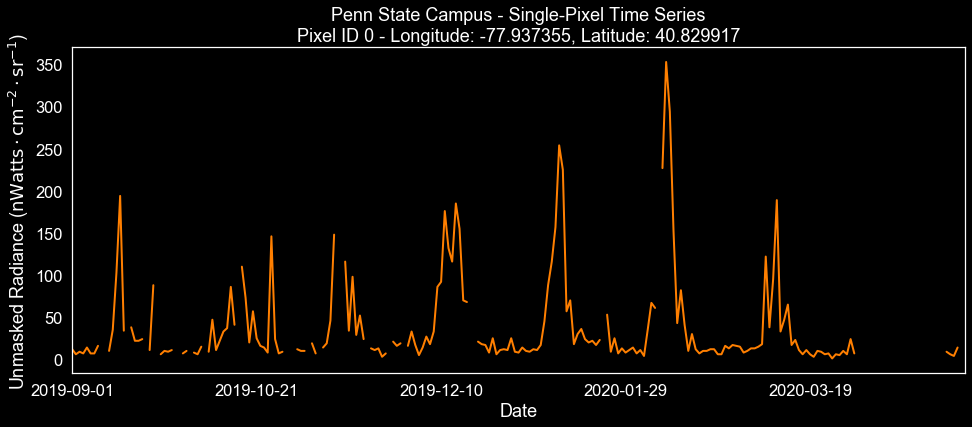

In [28]:
# Plot single-pixel time series
with plt.style.context('dark_background'):
    
    ax = pixel_id_0_radiance.plot(figsize=(16,6), grid=False, color='#ff7f00', linewidth=2)
    
    ax.set_title('Penn State Campus - Single-Pixel Time Series\nPixel ID 0 - Longitude: -77.937355, Latitude: 40.829917')
    ax.set_xlabel('Date')
    ax.set_ylabel('Unmasked Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)')

In [29]:
# Note - Change date format (both now YYYY-MM-DD)
#  makes the get cloud_mask_data() function not needed;
#  both can use the get_radiance_data() function

# Get Sept 2019 radiance value dataframes into list - FILLED
sept_2019_radiance_filled = get_radiance_data(
    psu_radiance_filled, year='2019', month='09')

# Get Sept 2019 cloud mask dataframes into list - FILLED
sept_2019_mask_filled = get_radiance_data(
    psu_cloud_mask_filled, year='2019', month='09')

In [30]:
sept_2019_radiance_filled[0].head()

,2019-09-01
0,12.0
1,11.0
2,11.0
3,11.0
4,11.0


In [31]:
sept_2019_mask_filled[0].head()

,2019-09-01
0,100.0
1,100.0
2,100.0
3,100.0
4,100.0


In [32]:
# Calculate mean radiance with filled data
sept_2019_mean_radiance_filled = calculate_mean_radiance(
    sept_2019_radiance_filled, sept_2019_mask_filled)

In [33]:
# Confirm mean radiance (should be 611.1739)
sept_2019_mean_radiance_filled.max()

611.1739130434783

### Create Plotting Extent

In [34]:
# Get min/max longitude and latitude values
lon_min = psu_lat_lon_df.Longitude.min()
lon_max = psu_lat_lon_df.Longitude.max()
lat_min = psu_lat_lon_df.Latitude.min()
lat_max = psu_lat_lon_df.Latitude.max()

In [35]:
# Display values
print(f"Lon min: {lon_min}\nLon max: {lon_max}\nLat min: {lat_min}\nLat max: {lat_max}")

Lon min: -77.93735504
Lon max: -77.77485504
Lat min: 40.75908399
Lat max: 40.82991733


In [36]:
# Get spacing for extent (assume lat/lon are centroids)
lon_spacing = (lon_max - lon_min) / 39
lat_spacing = (lat_max - lat_min) / 17

# Check to which decimal the lat and long spacings match
round(lon_spacing, 9) == round(lon_spacing, 9)

# Define single spacing
coord_spacing = round(lon_spacing, 9)

In [37]:
# Define extent
psu_extent = (
    lon_min - coord_spacing/2,
    lon_max + coord_spacing/2,
    lat_min - coord_spacing/2,
    lat_max + coord_spacing/2
)

In [38]:
# # Define extent
# psu_extent = (lon_min-0.004166999999995369/2, 
#               lon_max+0.004166999999995369/2, 
#               lat_min-0.004166999999995369/2, 
#               lat_max+0.004166999999995369/2)

In [39]:
# Show extent (xmin, xmax, ymin, ymax)
psu_extent

(-77.9394383735, -77.77277170650001, 40.7570006565, 40.832000663500004)

In [40]:
# Create geodataframe to store lat/lon points 
#  (for plotting over array)
psu_lat_lon_copy = psu_lat_lon_df.copy()

psu_lat_lon_gdf = gpd.GeoDataFrame(
    psu_lat_lon_copy, 
    crs="epsg:4326", 
    geometry=gpd.points_from_xy(
        psu_lat_lon_copy.Longitude, 
        psu_lat_lon_copy.Latitude)
)

In [41]:
# Display dataframe
psu_lat_lon_gdf.head()

,ID,Latitude,Longitude,geometry
0,0,40.829917,-77.937355,POINT (-77.93736 40.82992)
1,1,40.825751,-77.937355,POINT (-77.93736 40.82575)
2,2,40.821584,-77.937355,POINT (-77.93736 40.82158)
3,3,40.817417,-77.937355,POINT (-77.93736 40.81742)
4,4,40.813251,-77.937355,POINT (-77.93736 40.81325)


## Data Processing

Store all this in a dictionary, indexed by year and then month? Nested dictionaries. Do this by looping through list of tuples (YEAR, MONTH) for the get data function? Same for mean? 

### Calculate Mean Radiance for September 2019


In [49]:
# Get Sept 2019 radiance value dataframes into list
sept_2019_radiance = get_radiance_data(
    psu_radiance_filled, year='2019', month='09')

# Get Sept 2019 cloud mask dataframes into list
sept_2019_mask = get_radiance_data(
    psu_cloud_mask_filled, year='2019', month='09')

In [50]:
# Calculate mean radiance
sept_2019_mean_radiance = calculate_mean_radiance(
    sept_2019_radiance, sept_2019_mask)

In [51]:
# Display shape of array (should be 18 rows, 40 columns)
sept_2019_mean_radiance.shape

(18, 40)

### Calculate Mean Radiance for October 2019


In [52]:
# Get Oct 2019 radiance value dataframes into list
oct_2019_radiance = get_radiance_data(
    psu_radiance_filled, year='2019', month='10')

# Get Sept 2019 cloud mask dataframes into list
oct_2019_mask = get_radiance_data(
    psu_cloud_mask_filled, year='2019', month='10')

In [53]:
# Calculate mean radiance
oct_2019_mean_radiance = calculate_mean_radiance(
    oct_2019_radiance, oct_2019_mask)

In [54]:
# Display shape of array (should be 18 rows, 40 columns)
oct_2019_mean_radiance.shape

(18, 40)

### Calculate Mean Radiance for November 2019


In [55]:
# Get Nov 2019 radiance value dataframes into list
nov_2019_radiance = get_radiance_data(
    psu_radiance_filled, year='2019', month='11')

# Get Nov 2019 cloud mask dataframes into list
nov_2019_mask = get_radiance_data(
    psu_cloud_mask_filled, year='2019', month='11')

In [56]:
# Calculate mean radiance
nov_2019_mean_radiance = calculate_mean_radiance(
    nov_2019_radiance, nov_2019_mask)

In [57]:
# Display shape of array (should be 18 rows, 40 columns)
nov_2019_mean_radiance.shape

(18, 40)

### Calculate Mean Radiance for December 2019


In [58]:
# Get Dec 2019 radiance value dataframes into list
dec_2019_radiance = get_radiance_data(
    psu_radiance_filled, year='2019', month='12')

# Get Nov 2019 cloud mask dataframes into list
dec_2019_mask = get_radiance_data(
    psu_cloud_mask_filled, year='2019', month='12')

In [59]:
# Calculate mean radiance
dec_2019_mean_radiance = calculate_mean_radiance(
    dec_2019_radiance, dec_2019_mask)

In [60]:
# Display shape of array (should be 18 rows, 40 columns)
dec_2019_mean_radiance.shape

(18, 40)

### Calculate Mean Radiance for January 2020


In [61]:
# Get Jan 2020 radiance value dataframes into list
jan_2020_radiance = get_radiance_data(
    psu_radiance_filled, year='2020', month='01')

# Get Nov 2019 cloud mask dataframes into list
jan_2020_mask = get_radiance_data(
    psu_cloud_mask_filled, year='2020', month='01')

In [62]:
# Calculate mean radiance
jan_2020_mean_radiance = calculate_mean_radiance(
    jan_2020_radiance, jan_2020_mask)

In [63]:
# Display shape of array (should be 18 rows, 40 columns)
jan_2020_mean_radiance.shape

(18, 40)

### Calculate Mean Radiance for February 2020


In [64]:
# Get Feb 2020 radiance value dataframes into list
feb_2020_radiance = get_radiance_data(
    psu_radiance_filled, year='2020', month='02')

# Get Nov 2019 cloud mask dataframes into list
feb_2020_mask = get_radiance_data(
    psu_cloud_mask_filled, year='2020', month='02')

In [65]:
# Calculate mean radiance
feb_2020_mean_radiance = calculate_mean_radiance(
    feb_2020_radiance, feb_2020_mask)

In [66]:
# Display shape of array (should be 18 rows, 40 columns)
feb_2020_mean_radiance.shape

(18, 40)

### Calculate Mean Radiance for March 2020


In [67]:
# Get March radiance value dataframes into list
march_2020_radiance = get_radiance_data(
    psu_radiance_filled, year='2020', month='03')

# Get March cloud mask dataframes into list
march_2020_mask = get_radiance_data(
    psu_cloud_mask_filled, year='2020', month='03')

In [68]:
# Calculate mean radiance
march_2020_mean_radiance = calculate_mean_radiance(
    march_2020_radiance, march_2020_mask )

In [69]:
# Display shape of array (should be 18 rows, 40 columns)
march_2020_mean_radiance.shape

(18, 40)

### Calculate Mean Radiance for April 2020


In [70]:
# Get April 2020 radiance value dataframes into list
apr_2020_radiance = get_radiance_data(
    psu_radiance_filled, year='2020', month='04')

# Get Nov 2019 cloud mask dataframes into list
apr_2020_mask = get_radiance_data(
    psu_cloud_mask_filled, year='2020', month='04')

In [71]:
# Calculate mean radiance
apr_2020_mean_radiance = calculate_mean_radiance(
    apr_2020_radiance, apr_2020_mask)

In [72]:
# Display shape of array (should be 18 rows, 40 columns)
apr_2020_mean_radiance.shape

(18, 40)

### Create Dictionary of Mean Radiance


Figure out a way to have a user specify start day, end day (for weeks or individual days), start year, end year (for larger ranges of data).

**Make this a function?** With user input for start and end dates. *get_monthly_mean_radiance()*

Pseudocode

* User defines start year and end year, start month and end month
* month = user-defined start month (str)
* year = user-defined start year (str)
* Change year and month to ints?
* Find way to handle months that are '04' vs '4'
    * int('04') returns the same as int('4')
* While year <= year and month <= month:
    * Get radiance values and cloud mask for year, month
    * Calculate mean radiance
    * Add mean radiance array to dictionary based on year, month indexing
    * month += 1
    * if month == 13 (or month % 12 == 1):
        * month = 1
        * year += 1
        

For **days** calculation, creates dates with NaN values.

**Excpetions**: https://docs.python.org/3/library/exceptions.html

In [78]:
# Create date list for Sept 2019 to Apr 2020
sep_2019_apr_2020 = create_date_list('2019-09', '2020-04')

In [79]:
# Display list
sep_2019_apr_2020

[('2019', '09'),
 ('2019', '10'),
 ('2019', '11'),
 ('2019', '12'),
 ('2020', '01'),
 ('2020', '02'),
 ('2020', '03'),
 ('2020', '04')]

In [ ]:
# Create date list for Sept 2018 to Apr 2020
sep_2018_apr_2020 = create_date_list('2018-09', '2020-04')

In [ ]:
# Display list
sep_2018_apr_2020

In [ ]:
# Create date list for March 2020
march_2020 = create_date_list('2020-03', '2020-03')

In [ ]:
# Display list
march_2020

In [ ]:
# # Should raise exception
# create_date_list('2021-03', '2020-03')

In [ ]:
# # Should raise exception
# create_date_list('2020-04', '2020-03')

In [80]:
# Get mean radiance values (Sep 2019 - Apr 2020) into dictionary
sep_2019_apr_2020_dict = store_mean_radiance(
    radiance_df=psu_radiance_filled, 
    cloud_mask_df=psu_cloud_mask_filled, 
    date_list=sep_2019_apr_2020)

In [ ]:
# Get all top-level keys
sep_2019_apr_2020_dict.keys()

In [ ]:
# Get keys for 2019
sep_2019_apr_2020_dict.get('2019').keys()

In [ ]:
# Get keys for 2020
sep_2019_apr_2020_dict.get('2020').keys()

In [ ]:
# Get max value for March 2020 mean radiance array
sep_2019_apr_2020_dict.get('2020').get('03').max()

In [ ]:
# Get max value for Sept 2019 mean radiance array
sep_2019_apr_2020_dict.get('2019').get('09').max()

### Calculate Change in Mean Radiance from September 2019 to March 2020


In [ ]:
# Calculate difference in mean radiance at each pixel (manual way)
radiance_diff_sept2019_march2020 = march_2020_mean_radiance - sept_2019_mean_radiance

In [81]:
# Calculate difference in mean radiance at each pixel (dictionary way)
radiance_diff_sept2019_march2020_from_dict = sep_2019_apr_2020_dict.get(
    '2020').get('03') - sep_2019_apr_2020_dict.get('2019').get('09')

In [82]:
radiance_diff_sept2019_march2020_from_dict.min()

-261.05469845722297

## Data Visualization

### Plot Cloud Free Mean Radiance Values for September 2019

In [ ]:
# Create figure and axes object
fig, ax = plt.subplots(figsize=(20, 10))

# Plot radiance values
ep.plot_bands(
    sept_2019_mean_radiance,
    title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    #cmap='Greens_r',
    scale=False,
    extent=psu_extent, 
    ax=ax,
    vmax=sept_2019_mean_radiance.max())

# Plot lat/lon (centroids)
# psu_lat_lon_gdf.plot(ax=ax)

plt.show()

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        sept_2019_mean_radiance,
        hist_range=(0, sept_2019_mean_radiance.max()),
        colors='#984ea3',
        title='Distribution of the Mean Radiance (September 2019)',
        xlabel='Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', 
        ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

    plt.show()

### Plot Cloud Free Mean Radiance Values for March 2020

In [ ]:
# Create figure and axes object
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(
    march_2020_mean_radiance,
    title="March 2020 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    #cmap='Greens_r',
    scale=False,
    extent=psu_extent, 
    ax=ax, 
    vmax=sept_2019_mean_radiance.max())

plt.show()

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        march_2020_mean_radiance,
        hist_range=(0, sept_2019_mean_radiance.max()),
        colors='#984ea3',
        title='Distribution of the Mean Radiance (March 2020)',
        xlabel='Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)',
        ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

    plt.show()

### Plot Cloud Free Change in Mean Radiance Values from September 2019 to March 2020

In [ ]:
# Plot change in radiance values
ep.plot_bands(
    radiance_diff_sept2019_march2020, 
    title="Difference in Mean Radiance (March 2020 - September 2019)",
    cmap='RdBu_r',
    figsize=(20, 10),
    scale=False,
    vmin=radiance_diff_sept2019_march2020.min(),
    vmax=-radiance_diff_sept2019_march2020.min(),
    extent=psu_extent)

plt.show()

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        radiance_diff_sept2019_march2020,
        hist_range=(radiance_diff_sept2019_march2020.min(), -radiance_diff_sept2019_march2020.min()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

### Combined Plots

In [ ]:
# Plot
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(3, 1, figsize=(30, 20))

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    plt.subplots_adjust(hspace=0.15)
    plt.subplots_adjust(top=0.9)

    ep.plot_bands(
        sept_2019_mean_radiance, title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        scale=False,
        vmax=sept_2019_mean_radiance.max(),
        ax=ax[0],
        extent=psu_extent)

    ep.plot_bands(
        march_2020_mean_radiance, title="March 2020 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        scale=False,
        vmax=sept_2019_mean_radiance.max(),
        ax=ax[1],
        extent=psu_extent)

    ep.plot_bands(
        radiance_diff_sept2019_march2020, title="Change in Mean Radiance (September 2019 vs. March 2020) ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        cmap='RdBu_r',
        scale=False,
        vmin=radiance_diff_sept2019_march2020.min(),
        vmax=-radiance_diff_sept2019_march2020.min(),
        ax=ax[2],
        extent=psu_extent)

    # Add caption
    fig.text(0.5, .1, "Data Source: NASA Black Marble",
             ha='center', fontsize=16)
    
    ax[0].title.set_size(20)
    ax[1].title.set_size(20)
    ax[2].title.set_size(20)

plt.savefig(
    fname="penn-state-mean-radiance-change-sept2019-mar2020-values.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        radiance_diff_sept2019_march2020,
        #         bins=40,
        hist_range=(radiance_diff_sept2019_march2020.min(), -radiance_diff_sept2019_march2020.min()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

plt.savefig(
    fname="penn-state-mean-radiance-change-sept2019-mar2020-histogram.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

## Data Export

In [ ]:
# Define export output paths
sept_2019_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-sept2019.tif")

march_2020_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-march2020.tif")

radiance_diff_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-difference-sept2019-march2020.tif")

In [ ]:
# Define export transform
transform = from_origin(lon_min, lat_max, coord_spacing, coord_spacing)

# Define export metadata
psu_campus_metadata = {
    "driver": "GTiff",
    "dtype": radiance_diff_sept2019_march2020.dtype,
    "nodata": 0,
    "width": radiance_diff_sept2019_march2020.shape[1],
    "height": radiance_diff_sept2019_march2020.shape[0],
    "count": 1,
    "crs": psu_lat_lon_gdf.crs,  # +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs
    "transform": transform
}

In [ ]:
# Export September 2019 radiance
export_to_geotiff(
    array=sept_2019_mean_radiance,
    output_path=sept_2019_radiance_outpath,
    metadata=psu_campus_metadata)

# Export March 2020 radiance
export_to_geotiff(
    array=march_2020_mean_radiance,
    output_path=march_2020_radiance_outpath,
    metadata=psu_campus_metadata)

# Export radiance difference
export_to_geotiff(
    array=radiance_diff_sept2019_march2020,
    output_path=radiance_diff_outpath,
    metadata=psu_campus_metadata)